In [1]:
import warnings
warnings.filterwarnings("ignore")

import os
import cv2
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
from PIL import Image
import torch
from torch_geometric.loader import DataLoader
from tqdm import tqdm
import torch
import faiss
from prettytable import PrettyTable
import matplotlib.pyplot as plt

import os
import sys
import inspect

currentdir = os.path.dirname(os.path.abspath(inspect.getfile(inspect.currentframe())))
parentdir = os.path.dirname(currentdir)
sys.path.insert(0, parentdir) 

from dataloader.anaxnet import CustomDataset
from model.anaxnet_attn_multilayer import CustomModel
from common_metrics import compute_metrics

In [2]:
nine_class_labels = [
    'lung opacity', 
    'pleural effusion', 
    'atelectasis', 
    'enlarged cardiac silhouette',
    'pulmonary edema/hazy opacity', 
    'pneumothorax', 
    'consolidation', 
    'fluid overload/heart failure', 
    'pneumonia']

anatomy_names = [
    'right lung',
    'right apical zone',
    'right upper lung zone',
    'right mid lung zone',
    'right lower lung zone',
    'right hilar structures',
    'right costophrenic angle',
    'left lung',
    'left apical zone',
    'left upper lung zone',
    'left mid lung zone',
    'left lower lung zone',
    'left hilar structures',
    'left costophrenic angle',
    'mediastinum',
    'upper mediastinum',
    'cardiac silhouette',
    'trachea']

config = {
    'num_classes': 9,
    'batch_size': 16,
    'lr': 0.0001,
    'num_layers': 6,
    'dropout': 0.0,
    'graph_importance': 0.2,
    'is_global_feat': True,
    'contrastive': False,
    'matryoshka': False,
    'task': 'graph_transformer',
    'run': 'gt_fc_2_layer_no_global_feat_image_only_classification',
    'num_workers': 32
    }

In [3]:
def calculate_metric(targets):
    mAP, mHR, mRR = [], [], []

    for _, target in enumerate(targets):
        if target.sum() == 0:
            mAP.append(0)
            mHR.append(0)
            mRR.append(0)
            continue

        pos = 0
        found_hit = False
        AP = []
        for i, t in enumerate(target):
            if t:
                pos += 1
                AP.append(pos/(i+1))
                if not found_hit: mRR.append(1/(i+1))
                found_hit = True
        mHR.append(int(found_hit))
        mAP.append(np.mean(AP) if len(AP) > 0 else 0)

    return mAP, mHR, mRR

# Unique Retrieved

In [4]:
all_emb = np.load('/tmp/gt_fc_2_layer_no_global_feat_image_only_classification_emb_auc.npy')
all_labels = np.load('/tmp/gt_fc_2_layer_no_global_feat_image_only_classification_labels_auc.npy')

# all_emb = np.load('/tmp/gt_fc_2_layer_cls_multitask_emb_auc.npy')
# all_labels = np.load('/tmp/gt_fc_2_layer_cls_multitask_labels_auc.npy')

weights = np.load('data/mimic_cxr_jpg/test_weights.npy')

In [5]:
index = faiss.IndexFlatIP(all_emb.shape[1])
all_emb = all_emb / np.linalg.norm(all_emb, axis=1, keepdims=True)
index.add(all_emb)

In [6]:
retrieved_indices = []

for emb, query_labels in tqdm(zip(all_emb, all_labels), total=len(all_emb)):
    D, I = index.search(emb.reshape(1, -1), 4)

    retrieved_indices.append(I[:, 1:])

100%|██████████| 3191/3191 [00:01<00:00, 1615.74it/s]


In [7]:
retrieved_indices = np.concatenate(retrieved_indices, axis=0)
retrieved_indices.shape

(3191, 3)

In [8]:
ar, ct = np.unique(np.concatenate(retrieved_indices, axis=0), return_counts=True)
ar.shape, ct.shape

((2680,), (2680,))

In [9]:
all_labels[ar[np.argmax(ct)]]

array([ True,  True, False, False, False, False, False, False, False])

In [10]:
(weights*3191).astype(int)

array([1001,  501,  464,  453,  306,   35,  124,   63,  240])

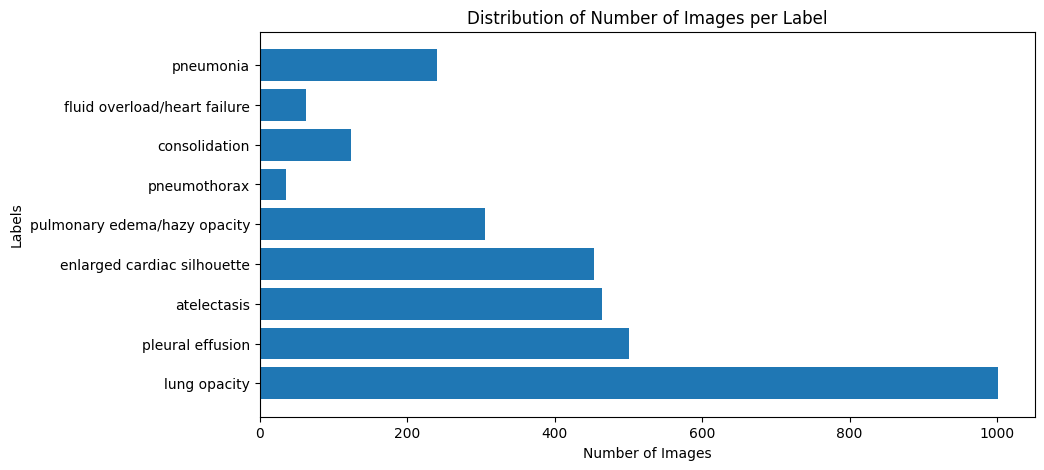

In [11]:
# horizontal plot the distribution of number of images per label
plt.figure(figsize=(10, 5))
plt.barh(np.arange(9), (weights*3191).astype(int))
plt.yticks(np.arange(9), nine_class_labels)
plt.xlabel('Number of Images')
plt.ylabel('Labels')
plt.title('Distribution of Number of Images per Label')
plt.show()

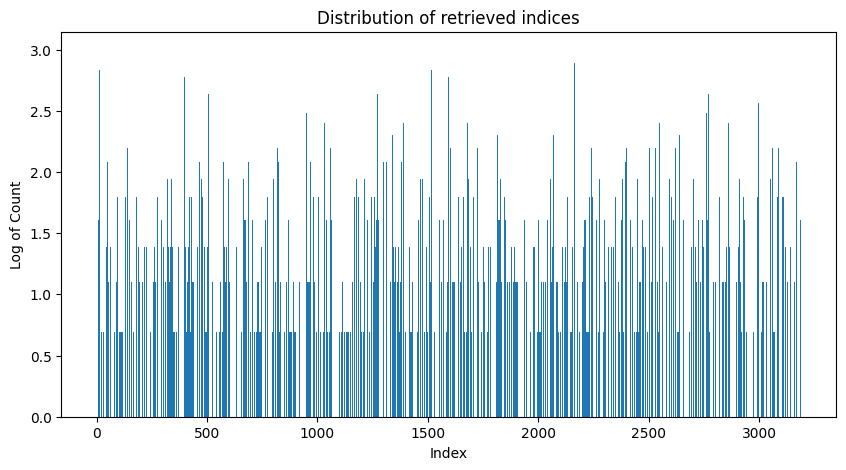

In [12]:
# plot the distribution of the retrieved indices
plt.figure(figsize=(10, 5))
plt.bar(ar, np.log(ct))
plt.xlabel('Index')
plt.ylabel('Log of Count')
plt.title('Distribution of retrieved indices')
plt.show()

# Cherry Pick

In [13]:
from model.ath import CustomModel as ATHModel
from model.anaxnet import CustomModel as AnaxModel
from model.graph_transformer import CustomModel as GTModel

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

config = {
    'lr': 0.0001,
    'num_layers': 2,
    'graph_importance': 1.0,
    'dropout': 0.0,
    'fully_connected': True,
    'contrastive': False,
    'image_featuriser': 'resnet',
    'multiscale': False,
    'is_global_feat': False,
    'cls': False,
    'matryoshka': False,
    'rel_pos': False,
    'abs_pos': False,
    'task': 'graph_transformer',
    'run': 'gt_fc_2_layer_no_global_feat_image_only_classification',
}
model_paths = sorted(glob(f'/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
best_model = GTModel.load_from_checkpoint(model_path, config=config)
best_model = best_model.eval()
best_model = best_model.to(device)

config = {
    'lr': 0.0001,
    'num_layers': 2,
    'graph_importance': 1.0,
    'dropout': 0.0,
    'fully_connected': True,
    'contrastive': False,
    'image_featuriser': 'resnet',
    'multiscale': False,
    'is_global_feat': True,
    'cls': True,
    'matryoshka': False,
    'rel_pos': False,
    'abs_pos': False,
    'pool': 'mean',
    'task': 'graph_transformer',
    'run': 'gt_fc_2_layer_cls_multitask',
}
model_paths = sorted(glob(f'/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
global_model = GTModel.load_from_checkpoint(model_path, config=config)
global_model = global_model.eval()
global_model = global_model.to(device)

config = {
    'lr': 0.0001,
    'dropout': 0.0,
    'task': 'anaxnet',
    'run': 'anaxnet',
}
model_paths = sorted(glob(f'/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
anaxnet_model = AnaxModel.load_from_checkpoint(model_path, config=config)
anaxnet_model = anaxnet_model.eval()
anaxnet_model = anaxnet_model.to(device)

config = {
    'lr': 0.0001,
    'dropout': 0.0,
    'hash_bits': 32,
    'task': 'ath',
    'run': 'ath',
}
model_paths = sorted(glob(f'/ssd_scratch/users/arihanth.srikar/checkpoints/mimic-cxr/{config["run"]}/*.ckpt'))
model_path = [md_name for md_name in model_paths if 'auc' in md_name][-1]
ath_model = ATHModel.load_from_checkpoint(model_path, config=config)
ath_model = ath_model.eval()
ath_model = ath_model.to(device)



Using CLS token
ATHNet: 32 bits, 9 classes


In [15]:
best_emb = np.load('/tmp/gt_fc_2_layer_no_global_feat_image_only_classification_emb_auc.npy')
best_labels = np.load('/tmp/gt_fc_2_layer_no_global_feat_image_only_classification_labels_auc.npy')

global_emb = np.load('/tmp/gt_fc_2_layer_cls_multitask_emb_auc.npy')
global_labels = np.load('/tmp/gt_fc_2_layer_cls_multitask_labels_auc.npy')

anaxnet_emb = np.load('/tmp/anaxnet_emb_auc.npy')
anaxnet_labels = np.load('/tmp/anaxnet_labels_auc.npy')

ath_emb = np.load('/tmp/ath_emb_auc.npy')
ath_labels = np.load('/tmp/ath_labels_auc.npy')

weights = np.load('data/mimic_cxr_jpg/test_weights.npy')

In [16]:
def extract_metrics(all_emb, all_labels, top_k=10):    

    index = faiss.IndexFlatIP(all_emb.shape[1])
    all_emb = all_emb / np.linalg.norm(all_emb, axis=1, keepdims=True)
    index.add(all_emb)

    # targets contains the retrieved labels checked against ground truth labels
    # predictions contain the distances of the retrieved labels
    all_targets_for_metric = {lbl_name: [] for lbl_name in nine_class_labels}
    all_similarity_for_metric = {lbl_name: [] for lbl_name in nine_class_labels}
    all_query_ids = {lbl_name: [] for lbl_name in nine_class_labels}
    all_retrieved_ids = {lbl_name: [] for lbl_name in nine_class_labels}

    # perform retrieval and save the input required for the metrics
    for query_id, (emb, query_labels) in enumerate(tqdm(zip(all_emb, all_labels), total=len(all_emb))):
        
        # expand dimension
        emb = emb[np.newaxis, ...]
        query_labels = query_labels[np.newaxis, ...]
        
        # perform retrieval
        D, I = index.search(emb, top_k+1)

        # find the corresponding labels from the retrieved indices
        # ignore the first one as it the query itself
        labels = all_labels[I[:, 1:]]
        similarity = torch.tensor(D[:, 1:])

        # we only care about query labels that are present
        target = torch.tensor(labels == 1)

        # class wise metrics
        for i, label_name in enumerate(nine_class_labels):
            
            # works with batched retrieval as well
            consider_batches = query_labels[:, i] == 1
            if consider_batches.sum() == 0:
                continue
            # extract only the relevant batches
            temp_target = target[consider_batches]
            temp_similarity = similarity[consider_batches]

            # save necessary values
            all_targets_for_metric[label_name].append(temp_target[:, :, i])
            all_similarity_for_metric[label_name].append(temp_similarity)
            all_query_ids[label_name].append(query_id)
            all_retrieved_ids[label_name].append(I[consider_batches, 1:].squeeze())

    # convert to tensors
    all_targets_for_metric = {k: torch.cat(v) for k, v in all_targets_for_metric.items()}
    all_similarity_for_metric = {k: torch.cat(v) for k, v in all_similarity_for_metric.items()}
    all_query_ids = {k: torch.tensor(v) for k, v in all_query_ids.items()}

    df = pd.DataFrame(columns=['Disease', 'mAP', 'mHR', 'mRR', 'query_id', 'retrieved_ids'])

    for k_diseases, v_diseases in all_targets_for_metric.items():
        mAP, mHR, mRR = calculate_metric(v_diseases)
        df_temp = pd.DataFrame({'Disease': [k_diseases]*len(mAP), 'mAP': mAP, 'mHR': mHR, 'mRR': mRR, 'query_id': all_query_ids[k_diseases], 'retrieved_ids': all_retrieved_ids[k_diseases]})
        df = pd.concat([df, df_temp])

    return df

In [17]:
top_k = 10
df_best_model = extract_metrics(best_emb, best_labels, top_k=top_k)
df_global_model = extract_metrics(global_emb, global_labels, top_k=top_k)
df_anaxnet = extract_metrics(anaxnet_emb, anaxnet_labels, top_k=top_k)
df_ath = extract_metrics(ath_emb, ath_labels, top_k=top_k)

  0%|          | 0/3191 [00:00<?, ?it/s]

100%|██████████| 3191/3191 [00:01<00:00, 3006.97it/s]


In [18]:
(best_labels == global_labels).all(), (best_labels == anaxnet_labels).all()

(True, True)

In [19]:
print("Loading dataset")
df = pd.read_json('/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/mimic_coco_filtered.json')
temp_df = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-final.csv')
temp_df.rename(columns={'dicom_id': 'image_id'}, inplace=True)
df = df.merge(temp_df, on='image_id', how='left')
print("Dataset loaded")

Loading dataset
Dataset loaded


In [20]:
from dataloader.anaxnet import OcclusionDataset, DiseaseOcclusionDataset

test_dataset = OcclusionDataset(df, split='test')

In [21]:
from torchvision import transforms
T = transforms.Compose([transforms.Resize((256, 256), antialias=True)])

In [22]:
def cosine_similarity(a, b):
    a = a.reshape(-1) if len(a.shape) > 1 else a
    b = b.reshape(-1) if len(b.shape) > 1 else b
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

In [23]:
def denomalize_image(image):
    image = image.permute(1, 2, 0).numpy()
    image -= np.min(image)
    image /= np.max(image)
    image = (image * 255).astype(np.uint8)
    return image

def print_image(sample, image_id=None):
    if isinstance(sample, torch.Tensor):
        image = denomalize_image(sample)
        diseases = []
    else:
        image = denomalize_image(sample['global_feat'])
    
        y = torch.sum(sample['y'], dim=0)
        diseases = [nine_class_labels[i] for i in range(9) if y[i] > 0]
    
    title = f"Image ID: {image_id}"
    plt.tick_params(axis='both', which='both', bottom=False, left=False, labelbottom=False, labelleft=False)
    plt.title(title)
    plt.imshow(image)

    return diseases

def print_query_retrieved_comparision(q, r1, r2, r3, q_id, r1_id, r2_id, r3_id):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    d1 = print_image(q, q_id)
    plt.subplot(1, 4, 2)
    d2 = print_image(r1, r1_id)
    plt.subplot(1, 4, 3)
    d3 = print_image(r2, r2_id)
    plt.subplot(1, 4, 4)
    d4 = print_image(r3, r3_id)
    plt.show()

    return d1, d2, d3, d4

def print_comparision(pick_idx, pick_pos=0, dataset=test_dataset):
    r1_ids = df_best_model[df_best_model['query_id'] == pick_idx]['retrieved_ids'].iloc[0]
    r1_id = r1_ids[pick_pos]

    r2_ids = df_anaxnet[df_anaxnet['query_id'] == pick_idx]['retrieved_ids'].iloc[0]
    r2_id = r2_ids[pick_pos]

    r3_ids = df_ath[df_ath['query_id'] == pick_idx]['retrieved_ids'].iloc[0]
    r3_id = r3_ids[pick_pos]

    d1, d2, d3, d4 = print_query_retrieved_comparision(dataset[pick_idx], dataset[r1_id], dataset[r2_id], dataset[r3_id], pick_idx, r1_id, r2_id, r3_id)

    print(f'Query Diseases:      {", ".join(d1)}')
    print(f'Best Model Diseases: {", ".join(d2)}')
    print(f'Anaxnet Diseases:    {", ".join(d3)}')
    print(f'ATH Diseases:        {", ".join(d4)}')

    return pick_idx, r1_id, r2_id, r3_id

In [24]:
cherry_pick_ids = [1934, 1519, 932, 270, 2, 2956, 915, 2564, 1773, 534]

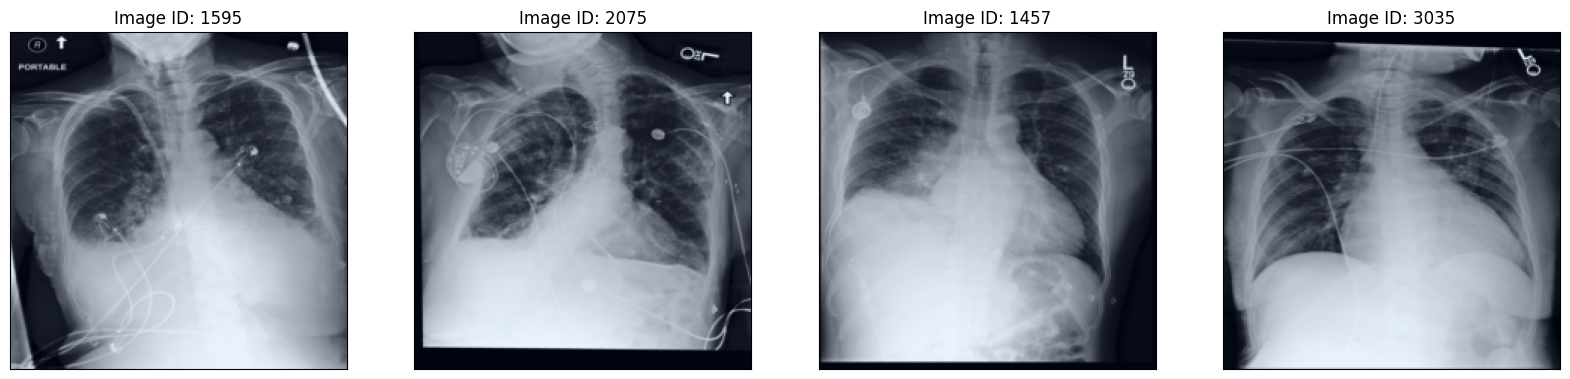

Query Diseases:      lung opacity, pleural effusion, atelectasis, enlarged cardiac silhouette, pulmonary edema/hazy opacity, consolidation
Best Model Diseases: lung opacity, enlarged cardiac silhouette, pulmonary edema/hazy opacity, consolidation, pneumonia
Anaxnet Diseases:    lung opacity, pleural effusion, consolidation, pneumonia
ATH Diseases:        lung opacity, enlarged cardiac silhouette, pulmonary edema/hazy opacity


In [25]:
threshold, pick_pos = 0.8, 0
pick_idx = np.random.choice(df_best_model[df_best_model['mRR'] - df_anaxnet['mRR'] > threshold]['query_id'], 1)[0]

_ = print_comparision(pick_idx, pick_pos, test_dataset)

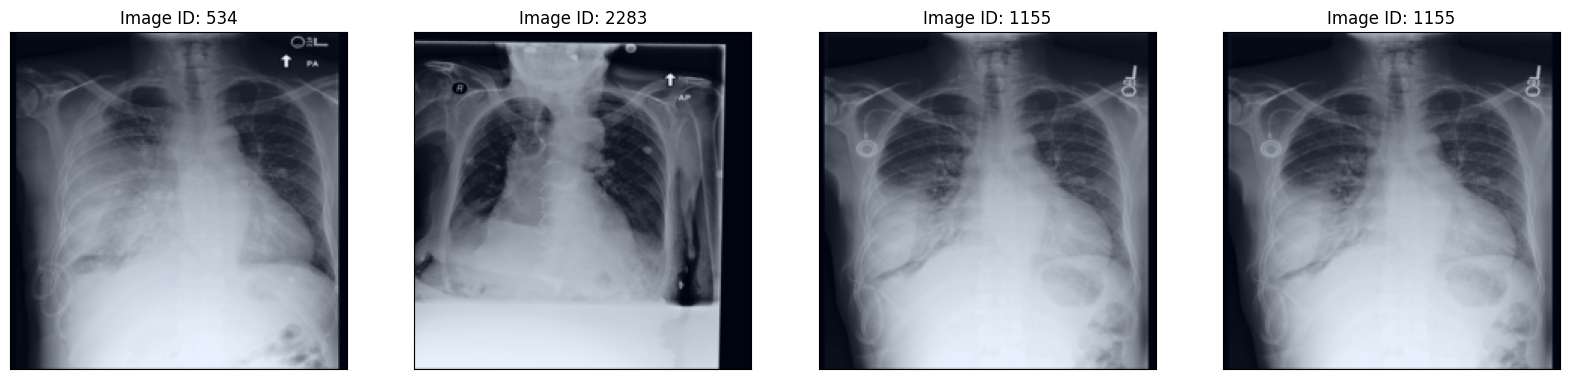

Query Diseases:      lung opacity, pleural effusion, atelectasis, enlarged cardiac silhouette, pulmonary edema/hazy opacity, pneumonia
Best Model Diseases: lung opacity, pleural effusion, atelectasis, enlarged cardiac silhouette, pulmonary edema/hazy opacity, pneumonia
Anaxnet Diseases:    lung opacity, pleural effusion, enlarged cardiac silhouette
ATH Diseases:        lung opacity, pleural effusion, enlarged cardiac silhouette


In [48]:
pick_idx = cherry_pick_ids[3]
pick_idx = cherry_pick_ids[-1]
_ = print_comparision(pick_idx, pick_pos, test_dataset)

In [49]:
sample = test_dataset[pick_idx]

In [50]:
y = sample['y']
all_y = (torch.sum(sample['y'], dim=0) > 0).int()
diseases = [nine_class_labels[i] for i in range(9) if all_y[i] > 0]
to_occlude = {d: [anatomy_names[i] for i, y_present in enumerate(y[:, diseases.index(d)]) if y_present] for d in diseases}
print(to_occlude)

{'lung opacity': ['right lung', 'right mid lung zone', 'right lower lung zone', 'right hilar structures', 'right costophrenic angle', 'left lung', 'left hilar structures'], 'pleural effusion': ['right lung', 'right mid lung zone', 'right lower lung zone', 'right costophrenic angle'], 'atelectasis': ['right lung', 'right mid lung zone', 'right lower lung zone', 'right costophrenic angle'], 'enlarged cardiac silhouette': ['cardiac silhouette'], 'pulmonary edema/hazy opacity': ['right lung', 'right hilar structures', 'left lung', 'left hilar structures'], 'pneumonia': []}


In [51]:
consider_disease = diseases[2]
print(f'Considering Disease: {consider_disease}')
# occluded_test_dataset = DiseaseOcclusionDataset(df, split='test', consider_disease=consider_disease)
occluded_test_dataset = OcclusionDataset(df, split='test', occlude_anatomy=to_occlude[consider_disease], precise=False)

Considering Disease: atelectasis


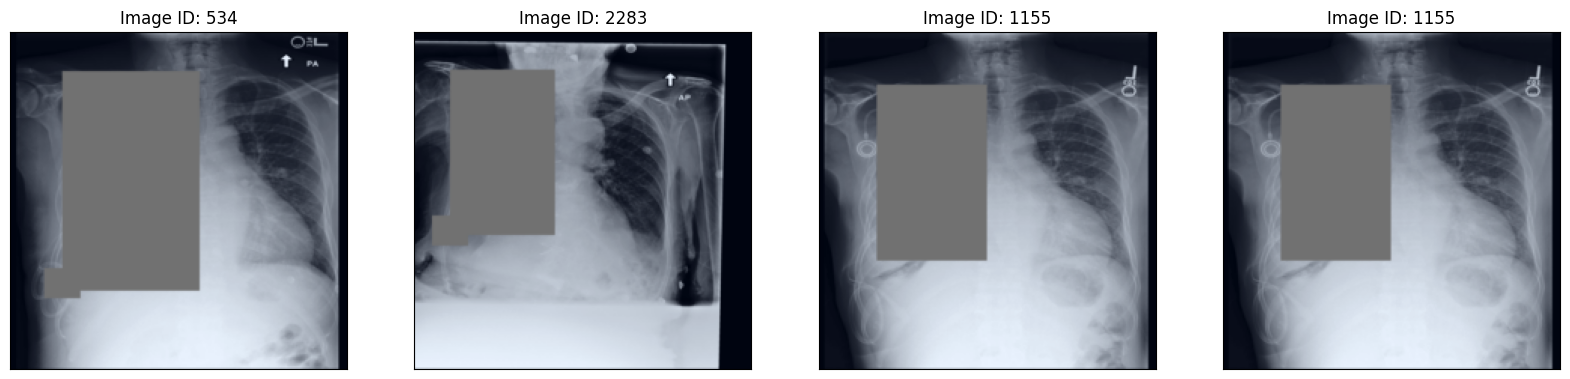

Query Diseases:      lung opacity, pleural effusion, atelectasis, enlarged cardiac silhouette, pulmonary edema/hazy opacity, pneumonia
Best Model Diseases: lung opacity, pleural effusion, atelectasis, enlarged cardiac silhouette, pulmonary edema/hazy opacity, pneumonia
Anaxnet Diseases:    lung opacity, pleural effusion, enlarged cardiac silhouette
ATH Diseases:        lung opacity, pleural effusion, enlarged cardiac silhouette


In [52]:
pick_idx, best_id, anaxnet_id, ath_id = print_comparision(pick_idx, pick_pos, occluded_test_dataset)

In [53]:
global_id = df_global_model[df_global_model['query_id'] == pick_idx]['retrieved_ids'].iloc[0][pick_pos]

In [54]:
best_occ_emb = best_model.retrieval_pass(occluded_test_dataset[best_id]['node_feat'].unsqueeze(0).to(device)).cpu().numpy()
global_occ_emb = global_model.retrieval_pass(occluded_test_dataset[global_id]['node_feat'].unsqueeze(0).to(device), occluded_test_dataset[global_id]['global_feat'].unsqueeze(0).to(device)).cpu().numpy()
anaxnet_occ_emb = anaxnet_model.retrieval_pass(occluded_test_dataset[anaxnet_id]['node_feat'].unsqueeze(0).to(device)).cpu().numpy()
ath_occ_emb = ath_model.retrieval_pass(T(occluded_test_dataset[ath_id]['global_feat'].unsqueeze(0)).to(device)).cpu().numpy()

In [55]:
print(f'Best Model Similarity:   {cosine_similarity(best_occ_emb, best_emb[pick_idx]):.2f}')
print(f'Global Model Similarity: {cosine_similarity(global_occ_emb, global_emb[pick_idx]):.2f}')
print(f'Anaxnet Similarity:      {cosine_similarity(anaxnet_occ_emb, anaxnet_emb[pick_idx]):.2f}')
print(f'ATH Similarity:          {cosine_similarity(ath_occ_emb, ath_emb[pick_idx]):.2f}')

Best Model Similarity:   0.69
Global Model Similarity: 0.93
Anaxnet Similarity:      0.83
ATH Similarity:          0.77


In [56]:
sample = test_dataset[pick_idx]
y = sample['y']
all_y = (torch.sum(sample['y'], dim=0) > 0).int()
diseases = [nine_class_labels[i] for i in range(9) if all_y[i] > 0]
to_occlude = {d: [anatomy_names[i] for i, y_present in enumerate(y[:, diseases.index(d)]) if y_present] for d in diseases}
occluded_dict = {'original': []}
for k, v in to_occlude.items():
    for a in v:
        if a in occluded_dict:
            # if a == 'right lung' or a == 'left lung': continue
            if k not in occluded_dict[a]:
                occluded_dict[a].append(k)
        else:
            occluded_dict[a] = [k]
similarities = {}
masked_images = {}

for anat, occ_anat_diseases in occluded_dict.items():
    # if anat == 'right lung' or anat == 'left lung': continue
    occ_anat = [] if anat == 'original' else [anat]
    occluded_test_dataset = OcclusionDataset(df, split='test', occlude_anatomy=occ_anat, precise=False)
    print(f'Occluding {occ_anat} for {", ".join(occ_anat_diseases)}')

    best_occ_emb = best_model.retrieval_pass(occluded_test_dataset[best_id]['node_feat'].unsqueeze(0).to(device)).cpu().numpy()
    global_id = df_global_model[df_global_model['query_id'] == pick_idx]['retrieved_ids'].iloc[0][pick_pos]
    global_occ_emb = global_model.retrieval_pass(occluded_test_dataset[global_id]['node_feat'].unsqueeze(0).to(device), occluded_test_dataset[global_id]['global_feat'].unsqueeze(0).to(device)).cpu().numpy()
    anaxnet_occ_emb = anaxnet_model.retrieval_pass(occluded_test_dataset[anaxnet_id]['node_feat'].unsqueeze(0).to(device)).cpu().numpy()
    ath_occ_emb = ath_model.retrieval_pass(T(occluded_test_dataset[ath_id]['global_feat'].unsqueeze(0)).to(device)).cpu().numpy()
    
    similarities[anat] = {
        'best': cosine_similarity(best_occ_emb, best_emb[pick_idx]),
        'global': cosine_similarity(global_occ_emb, global_emb[pick_idx]),
        'anaxnet': cosine_similarity(anaxnet_occ_emb, anaxnet_emb[pick_idx]),
        'ath': cosine_similarity(ath_occ_emb, ath_emb[pick_idx])
    }

    masked_images[anat] = {
        'best': occluded_test_dataset[best_id]['masked_img'],
        'global': occluded_test_dataset[global_id]['masked_img'],
        'anaxnet': occluded_test_dataset[anaxnet_id]['masked_img'],
        'ath': occluded_test_dataset[ath_id]['masked_img']
    }

Occluding [] for 
Occluding ['right lung'] for lung opacity, pleural effusion, atelectasis, pulmonary edema/hazy opacity
Occluding ['right mid lung zone'] for lung opacity, pleural effusion, atelectasis
Occluding ['right lower lung zone'] for lung opacity, pleural effusion, atelectasis


Occluding ['right hilar structures'] for lung opacity, pulmonary edema/hazy opacity
Occluding ['right costophrenic angle'] for lung opacity, pleural effusion, atelectasis
Occluding ['left lung'] for lung opacity, pulmonary edema/hazy opacity
Occluding ['left hilar structures'] for lung opacity, pulmonary edema/hazy opacity
Occluding ['cardiac silhouette'] for enlarged cardiac silhouette


In [57]:
t = PrettyTable(['Anatomy', 'Best Model', 'Global Model', 'Anaxnet', 'ATH'])
t.title = 'Similarity Difference in % for Occluded Anatomies'

for anat, anat_dict in similarities.items():
    if anat == 'original': continue
    row = [anat]
    for model, sim in anat_dict.items():
        orig = similarities['original'][model]
        diff = 100 * (orig - sim) / orig
        row.append(f'{diff:.2f}')
    t.add_row(row)

print(t)

+------------------------------------------------------------------------+
|           Similarity Difference in % for Occluded Anatomies            |
+--------------------------+------------+--------------+---------+-------+
|         Anatomy          | Best Model | Global Model | Anaxnet |  ATH  |
+--------------------------+------------+--------------+---------+-------+
|        right lung        |   26.81    |     5.94     |   9.51  | 10.29 |
|   right mid lung zone    |    5.78    |     1.14     |   0.09  |  2.46 |
|  right lower lung zone   |    3.75    |     1.75     |   3.53  |  0.94 |
|  right hilar structures  |    4.22    |     0.75     |   1.61  |  2.44 |
| right costophrenic angle |    2.74    |     0.00     |  -0.15  | -2.30 |
|        left lung         |   27.11    |     2.85     |   6.37  | 20.08 |
|  left hilar structures   |    4.22    |     0.71     |   0.24  |  0.40 |
|    cardiac silhouette    |   12.10    |     2.68     |   6.17  | -2.00 |
+------------------------

In [58]:
masked_images['original'].keys()

dict_keys(['best', 'global', 'anaxnet', 'ath'])

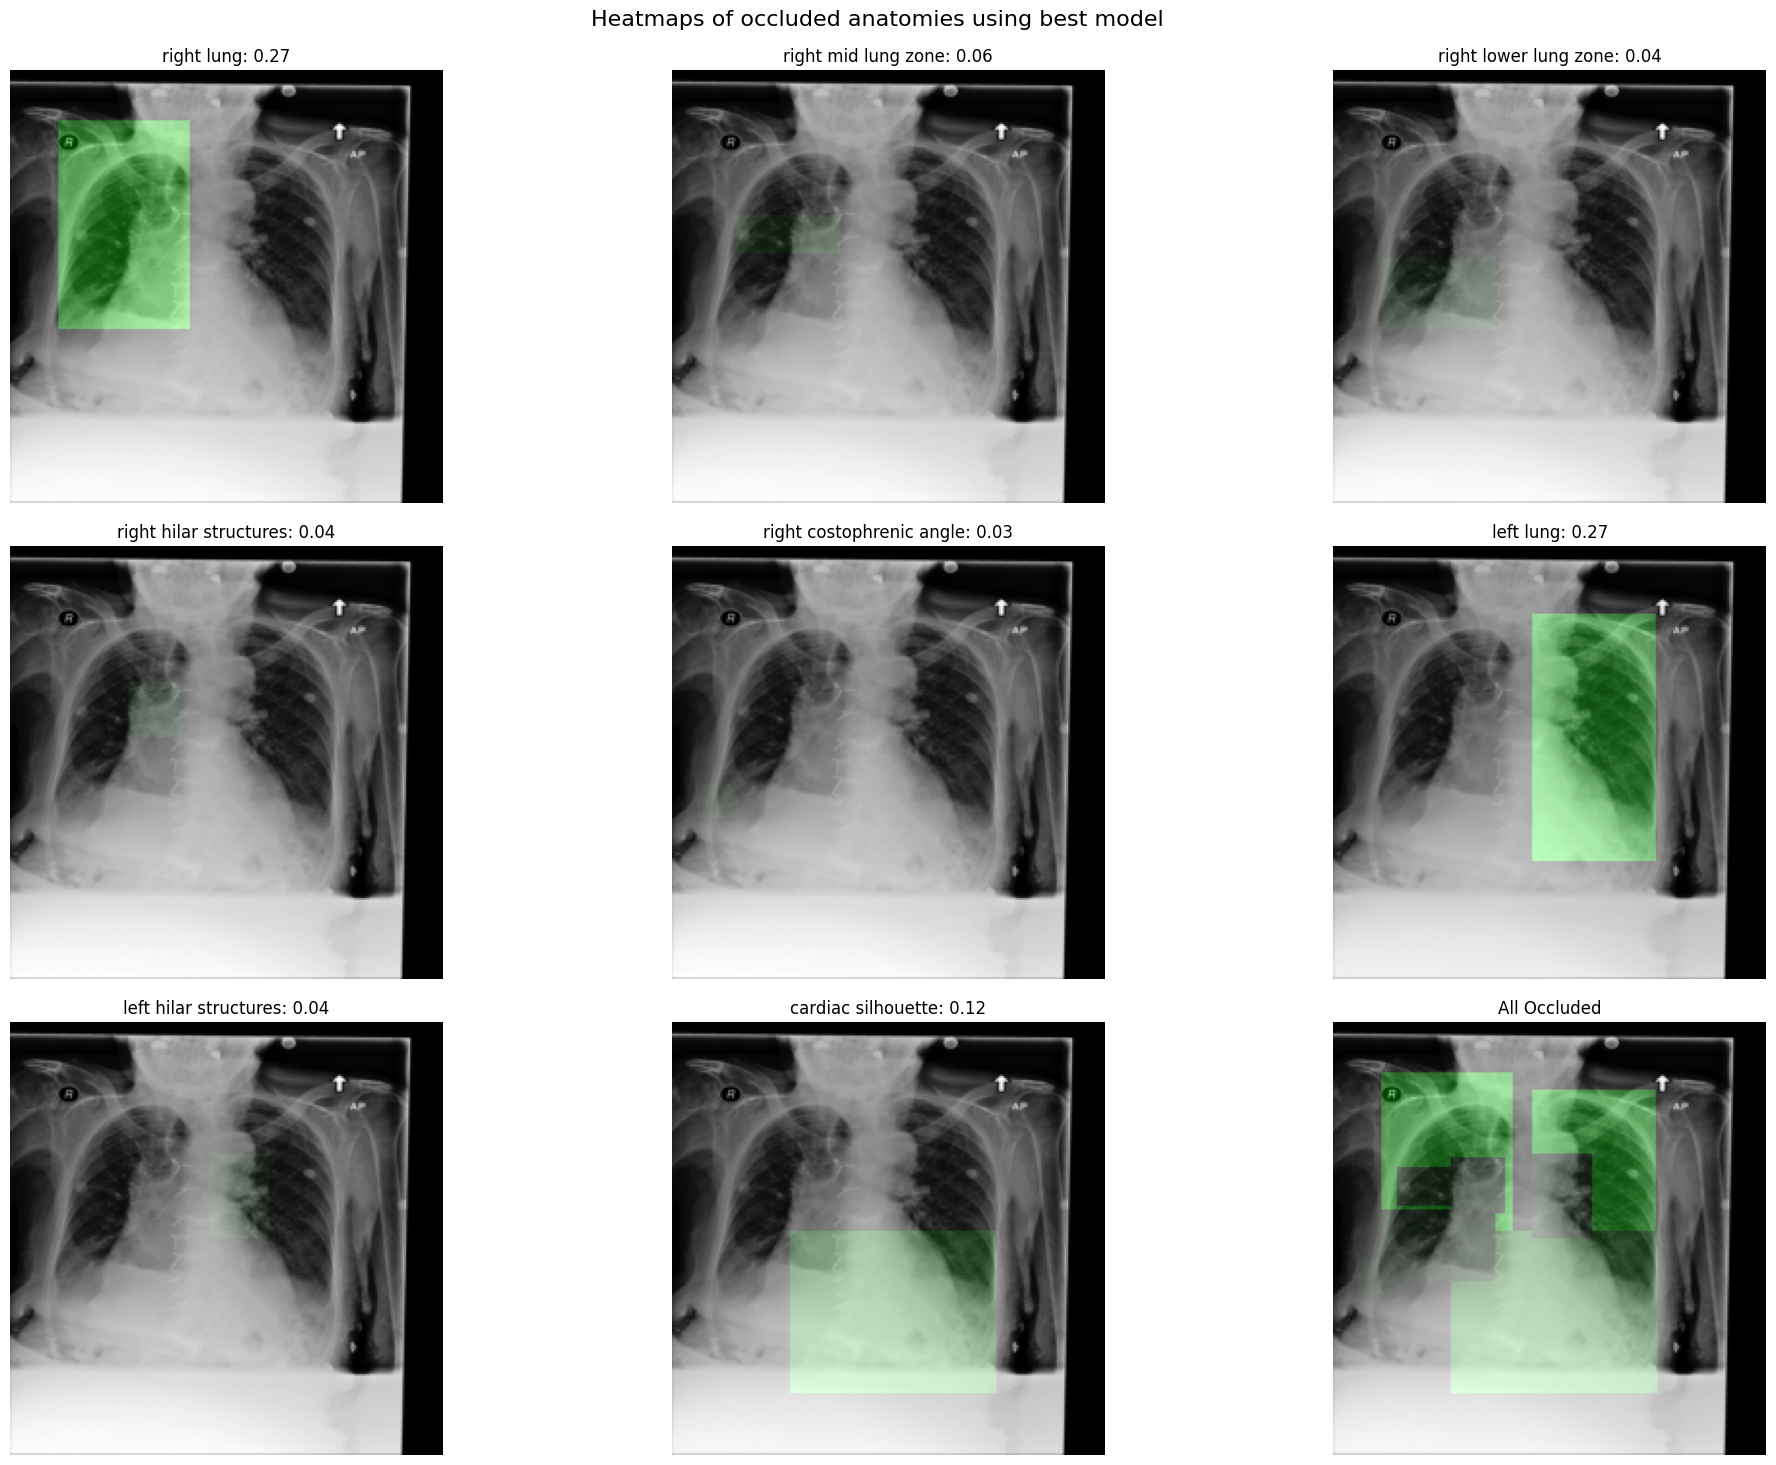

In [60]:
consider_model = ['best', 'global', 'anaxnet', 'ath'][0]

original_image = test_dataset[best_id]['global_feat']
original_image = torch.sum(original_image, dim=0).repeat(3, 1, 1)
original_image = original_image - original_image.min()
original_image = original_image / original_image.max()
global_heatmap = np.uint8(np.ones((224, 224, 3))*255)

# plot the heatmaps for all the occluded anatomies
num_cols = 3
num_rows = len(masked_images)//num_cols + 1
fig, axes = plt.subplots(num_rows, num_cols, figsize=(20, 20))
axes = axes.flatten()
fig.suptitle(f'Heatmaps of occluded anatomies using {consider_model} model', fontsize=16)
fig.tight_layout()
fig.subplots_adjust(top=0.95)

cnt = 0
for i, (anat, img_dict) in enumerate(masked_images.items()):
    if anat == 'original': continue
    for model, masked_img in img_dict.items():
        if model != consider_model: continue
        orig = similarities['original'][model]
        curr = similarities[anat][model]
        diff = np.abs(orig - curr) / orig

        heatmap = ((masked_img == 0).float()).permute(1, 2, 0).numpy()
        heatmap -= np.min(heatmap)
        heatmap = heatmap / np.max(heatmap)
        heatmap = np.uint8(heatmap * 255 * diff)
        global_heatmap = np.where((heatmap < global_heatmap) & (heatmap != heatmap.min()), heatmap, global_heatmap)
        # heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_OCEAN)
        heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_DEEPGREEN)
        
        superimposed_img = heatmap/255 + original_image.permute(1, 2, 0).numpy()
        superimposed_img -= np.min(superimposed_img)
        superimposed_img = superimposed_img / np.max(superimposed_img)
        superimposed_img = np.uint8(superimposed_img * 255)

        # create vertical subplots
        axes[cnt].imshow(superimposed_img)
        axes[cnt].axis('off')
        axes[cnt].set_title(f'{anat}: {diff:.2f}')
        cnt += 1

global_heatmap = np.where(global_heatmap == global_heatmap.max(), 0, global_heatmap)
# axes[cnt].imshow(global_heatmap)
# axes[cnt].axis('off')
# axes[cnt].set_title(f'Global Heatmap')
# cnt += 1

global_heatmap = cv2.applyColorMap(global_heatmap, cv2.COLORMAP_DEEPGREEN)
superimposed_img = global_heatmap/255 + original_image.permute(1, 2, 0).numpy()
superimposed_img -= np.min(superimposed_img)
superimposed_img = superimposed_img / np.max(superimposed_img)
superimposed_img = np.uint8(superimposed_img * 255)
axes[cnt].imshow(superimposed_img)
axes[cnt].axis('off')
axes[cnt].set_title(f'All Occluded')
cnt += 1

while cnt < len(axes):
    fig.delaxes(axes[cnt])
    cnt += 1
plt.show()

In [5]:
from tqdm import tqdm
import numpy as np
import pandas as pd
from glob import glob
import torch
from torch.utils.data import DataLoader

from dataloader.anaxnet import OcclusionDataset
from common_metrics import compute_metrics

In [3]:
print("Loading dataset")
df = pd.read_json('/ssd_scratch/users/arihanth.srikar/physionet.org/files/chest-imagenome/1.0.0/silver_dataset/mimic_coco_filtered.json')
temp_df = pd.read_csv('data/mimic_cxr_jpg/mimic-cxr-2.0.0-final.csv')
temp_df.rename(columns={'dicom_id': 'image_id'}, inplace=True)
df = df.merge(temp_df, on='image_id', how='left')
print("Dataset loaded")

Dataset loaded


In [8]:
test_dataset = OcclusionDataset(df, split='test')
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [13]:
seventeen_class_labels = [
    'right lung opacity', 
    'right pleural effusion', 
    'right atelectasis', 
    'right pulmonary edema/hazy opacity', 
    'right pneumothorax', 
    'right consolidation', 
    'right fluid overload/heart failure', 
    'right pneumonia',
    'left lung opacity', 
    'left pleural effusion', 
    'left atelectasis', 
    'left pulmonary edema/hazy opacity', 
    'left pneumothorax', 
    'left consolidation', 
    'left fluid overload/heart failure', 
    'left pneumonia',
    'center enlarged cardiac silhouette',
    ]

twentyseven_class_labels = [
    'right lung opacity', 
    'right pleural effusion', 
    'right atelectasis', 
    'right enlarged cardiac silhouette',
    'right pulmonary edema/hazy opacity', 
    'right pneumothorax', 
    'right consolidation', 
    'right fluid overload/heart failure', 
    'right pneumonia',
    'left lung opacity', 
    'left pleural effusion', 
    'left atelectasis', 
    'left enlarged cardiac silhouette',
    'left pulmonary edema/hazy opacity', 
    'left pneumothorax', 
    'left consolidation', 
    'left fluid overload/heart failure', 
    'left pneumonia',
    'center lung opacity', 
    'center pleural effusion', 
    'center atelectasis', 
    'center enlarged cardiac silhouette',
    'center pulmonary edema/hazy opacity', 
    'center pneumothorax', 
    'center consolidation', 
    'center fluid overload/heart failure', 
    'center pneumonia',
    ]

In [14]:
for i, batch in enumerate(tqdm(test_loader)):
    y = torch.sum(batch['y'], dim=1) > 0

    only_right = torch.sum(batch['y'][:, :7], dim=1) > 0
    only_left = torch.sum(batch['y'][:, 7:14], dim=1) > 0
    middle = torch.sum(batch['y'][:, 14:], dim=1) > 0
    right_and_left_labels = torch.cat([only_right, only_left, middle], dim=1)

    print(f'y: {y.shape}')
    print(f'only_right: {only_right.shape}')
    print(f'only_left: {only_left.shape}')
    print(f'right_and_left_labels: {right_and_left_labels.shape}')

    req_indices = [twentyseven_class_labels.index(lbl_name) for lbl_name in seventeen_class_labels]
    consider_labels = right_and_left_labels[:, req_indices]

    print(f'consider_labels: {consider_labels.shape}')

    break

  0%|          | 0/399 [00:01<?, ?it/s]

y: torch.Size([8, 9])
only_right: torch.Size([8, 9])
only_left: torch.Size([8, 9])
right_and_left_labels: torch.Size([8, 27])
consider_labels: torch.Size([8, 17])
